# Get the data
Same as in EDA notbook

In [49]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import re
import seaborn as sns
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [53]:
df = pd.read_csv("../data/data_clean_new.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)
df = df.drop("Unnamed: 0", axis = 1)

In [50]:
df.stars.value_counts()

3.5    12826
4.0    12809
3.0     9414
4.5     5875
2.5     5075
2.0     2762
1.5      933
5.0      929
1.0      216
Name: stars, dtype: int64

In [54]:
for column in df.columns :
    if df[column][0] == 'True' or df[column][0] =='False':
    #This tests if the column is a boolean by using the first row for efficiency    
        df[column] = df[column]=='True'
        
    #for some columns we have NaN, in that case we test if we find a True or False value
    elif "True" in df[column].values :
        df[column] = df[column]=='True'
    elif "False" in df[column].values :
        df[column] = df[column]=='True'

In [55]:
cuisine_type = ["American (New)","American (Traditional)","Arts & Entertainment","Asian Fusion","Bakeries","Barbeque","Bars",
"Beer","Breakfast & Brunch","Buffets","Burgers","Cafes","Canadian (New)","Caribbean","Caterers","Chicken Wings",
"Chinese","Cocktail Bars","Coffee & Tea","Comfort Food","Delis","Desserts","Diners","Ethnic Food",
"Event Planning & Services","Fast Food","Food","Food Delivery Services","French","Gastropubs","Gluten-Free",
"Greek","Grocery","Halal","Hot Dogs","Ice Cream & Frozen Yogurt","Indian","Italian","Japanese","Juice Bars & Smoothies",
"Korean","Latin American","Lounges","Mediterranean","Mexican","Middle Eastern","Nightlife","Pizza","Pubs",
"Salad","Sandwiches","Seafood","Soup","Specialty Food","Sports Bars","Steakhouses","Sushi Bars","Tex-Mex",
"Thai","Vegan","Vegetarian","Vietnamese","Wine & Spirits","Wine Bars"]

ambiance = ["romantic","intimate","classy","hipster","divey","touristy","trendy","upscale","casual"]

In [56]:
for column in df[cuisine_type] :
    df[column] = df[column]=="1"

In [57]:
df['stars']=df['stars'].astype(float)
df.Price = pd.to_numeric(df.Price, errors='coerce')
df = df[np.isfinite(df['Price'])]

In [58]:
df.columns

Index(['address', 'business_id', 'city', 'is_open', 'latitude', 'longitude',
       'name', 'postal_code', 'review_count', 'stars', 'state', 'Price',
       'American (New)', 'American (Traditional)', 'Arts & Entertainment',
       'Asian Fusion', 'Bakeries', 'Barbeque', 'Bars', 'Beer',
       'Breakfast & Brunch', 'Buffets', 'Burgers', 'Cafes', 'Canadian (New)',
       'Caribbean', 'Caterers', 'Chicken Wings', 'Chinese', 'Cocktail Bars',
       'Coffee & Tea', 'Comfort Food', 'Delis', 'Desserts', 'Diners',
       'Ethnic Food', 'Event Planning & Services', 'Fast Food', 'Food',
       'Food Delivery Services', 'French', 'Gastropubs', 'Gluten-Free',
       'Greek', 'Grocery', 'Halal', 'Hot Dogs', 'Ice Cream & Frozen Yogurt',
       'Indian', 'Italian', 'Japanese', 'Juice Bars & Smoothies', 'Korean',
       'Latin American', 'Lounges', 'Mediterranean', 'Mexican',
       'Middle Eastern', 'Nightlife', 'Pizza', 'Pubs', 'Salad', 'Sandwiches',
       'Seafood', 'Soup', 'Specialty Food', 'Spo

In [59]:
df["review_count"]= df["review_count"].astype(int)
df["name_length"]= df["name_length"].astype(int)

In [32]:
df.columns

Index(['address', 'business_id', 'city', 'is_open', 'latitude', 'longitude',
       'name', 'postal_code', 'review_count', 'stars', 'state', 'Price',
       'American (New)', 'American (Traditional)', 'Arts & Entertainment',
       'Asian Fusion', 'Bakeries', 'Barbeque', 'Bars', 'Beer',
       'Breakfast & Brunch', 'Buffets', 'Burgers', 'Cafes', 'Canadian (New)',
       'Caribbean', 'Caterers', 'Chicken Wings', 'Chinese', 'Cocktail Bars',
       'Coffee & Tea', 'Comfort Food', 'Delis', 'Desserts', 'Diners',
       'Ethnic Food', 'Event Planning & Services', 'Fast Food', 'Food',
       'Food Delivery Services', 'French', 'Gastropubs', 'Gluten-Free',
       'Greek', 'Grocery', 'Halal', 'Hot Dogs', 'Ice Cream & Frozen Yogurt',
       'Indian', 'Italian', 'Japanese', 'Juice Bars & Smoothies', 'Korean',
       'Latin American', 'Lounges', 'Mediterranean', 'Mexican',
       'Middle Eastern', 'Nightlife', 'Pizza', 'Pubs', 'Salad', 'Sandwiches',
       'Seafood', 'Soup', 'Specialty Food', 'Spo

# Base rate
The base rate is the size of the most common class divided by the size of the dataset.
Our accuracy should be better than the default rate

In [33]:
print("The most common class for the ratings is ", df["stars"].mode())

baseRate = df[df["stars"] == 3.5].count()["stars"] / df["stars"].count()
baseRate

The most common class for the ratings is  0    3.5
dtype: float64


0.25228663034284704

# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [163]:
#mean normalisation
#df["normalized_review_count"]=(df["review_count"]-df["review_count"].mean())/df["review_count"].std()

#min-max normalisation 
#df["normalized_review_count"]=(df["review_count"]-df["review_count"].min())/(df["review_count"].max()-df["review_count"].min())

In [35]:
#df["filter_stars"] = df[df["stars"] != 1]["stars"]
#df["filter_stars"] = df["filter_stars"].dropna()

In [60]:
from imblearn.over_sampling import SMOTE
X = df.drop(['stars', "name", "address", "business_id", "city", "state", 'postal_code'], axis = 1)
y = df['stars']
X_resampled, y_resampled = SMOTE().fit_resample(X, y) # upsampling

C:\Games\Python\lib\site-packages\imblearn\utils\_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got continuous instead.
  TARGET_KIND, type_of_target(y)))


In [38]:
#balance classes

#balanced = pd.DataFrame(columns=df.columns) #create empty df
#for i in df["filter_stars"].dropna().unique():
  #  balanced = balanced.append(df[df["filter_stars"] == i].sample(900))


In [39]:
#balanced["stars"].value_counts()

5.0    900
1.5    900
2.0    900
4.5    900
3.5    900
3.0    900
4.0    900
2.5    900
Name: stars, dtype: int64

In [40]:

#X = df[["name_length", "normalized_review_count", "Price", "American (New)", "Sandwiches"]]
#X = balanced.drop(["stars","filter_stars", "name", "address", "business_id", "city", "state", "review_count", 'postal_code'], axis = 1)
#y = balanced["stars"]


In [61]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y_resampled) #we label encode the star ratings

In [62]:
# split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, encoded, test_size=0.2, random_state=72)

In [63]:
LR = LogisticRegression(solver='lbfgs', max_iter=2000, multi_class = "auto")
LR.fit(X_train, y_train)

KeyboardInterrupt: 

In [44]:
# train accuracy
#lbfgs: 0.29628
#newton-cg: 0.2962
LR.score(X_train,y_train)

0.29756944444444444

In [45]:
# test accuracy
#lbfgs: 0.29015
#newton-cg: 29015
LR.score(X_test, y_test)

0.25555555555555554

Our test accuracy is above the baserate but it isn't really a good result

In [64]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

clf = RandomForestClassifier(n_estimators = 200,max_depth = 10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
print(clf.score(X_train,y_train))
print(clf.score(X_test, y_test))

0.4856357001310275
0.44522891670637155


C:\Games\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.02429871 0.19651134 0.1943423  0.04582726 0.01600809 0.01046264
 0.00422792 0.00755611 0.00580123 0.00670292 0.00474234 0.00270984
 0.01431423 0.00349125 0.0125561  0.00743265 0.0079138  0.00310862
 0.00379166 0.00909557 0.00533239 0.00268526 0.00783353 0.00441506
 0.00662325 0.00456704 0.00742318 0.00160163 0.00601808 0.02231855
 0.01498887 0.00291801 0.00300521 0.00242303 0.0044478  0.00458751
 0.00286745 0.00305596 0.00499603 0.00424059 0.00439042 0.01295383
 0.0071173  0.00326795 0.0044972  0.00313822 0.00263625 0.00645521
 0.00753826 0.00517879 0.00549471 0.01000043 0.00270351 0.01052066
 0.01977346 0.00980551 0.00472196 0.00432052 0.00331957 0.00561866
 0.00481754 0.00309699 0.00469912 0.00310531 0.00380738 0.00427188
 0.00243273 0.00202694 0.00362452 0.13742218]


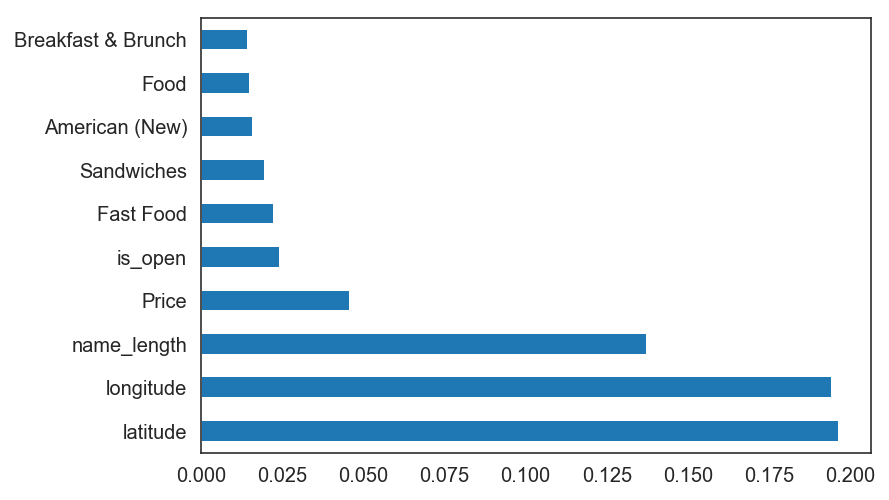

In [48]:
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [31]:
df = df[np.isfinite(df['Price'])]

In [87]:
np.any(np.isnan(df["Price"]))

False

In [85]:
np.all(np.isfinite(df["Price"]))

False

In [98]:
X = df[["name_length","Price"]]
y = df["stars"]

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y) #we label encode the star ratings

# split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded, test_size=0.2, random_state=72)

In [100]:
LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=500, multi_class = "auto")
LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=500, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [101]:
print("Train accuracy :",LR.score(X_train,y_train))
print("Test accuracy :",LR.score(X_test, y_test))

Train accuracy : 0.25722458559483646
Test accuracy : 0.263348327791903
